<img src="https://learnopencv.com/wp-content/uploads/2022/04/model-compile-768x418.png">

In [3]:
# !pip install ultralytics

In [1]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob 
import random
import os
from ultralytics import YOLO

In [4]:
os.makedirs('datasets', exist_ok=True)

In [5]:
%cd datasets

/home/jaykumaran/Blogs/Poth-hole-Detection/datasets


/home/jaykumaran/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Download the Dataset

In [7]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)
        
download_file(
    'https://www.dropbox.com/s/qvglw8pqo16769f/pothole_dataset_v8.zip?dl=1',
    'pothole_dataset_v8.zip'
)

In [8]:
# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('pothole_dataset_v8.zip')

Extracted all


In [8]:
%cd ..

/home/jaykumaran/Blogs/Poth-hole-Detection


## Visualize Images from the Dataset

In [4]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [5]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))
                
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [6]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))
    
    all_images.sort()

    num_images = len(all_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

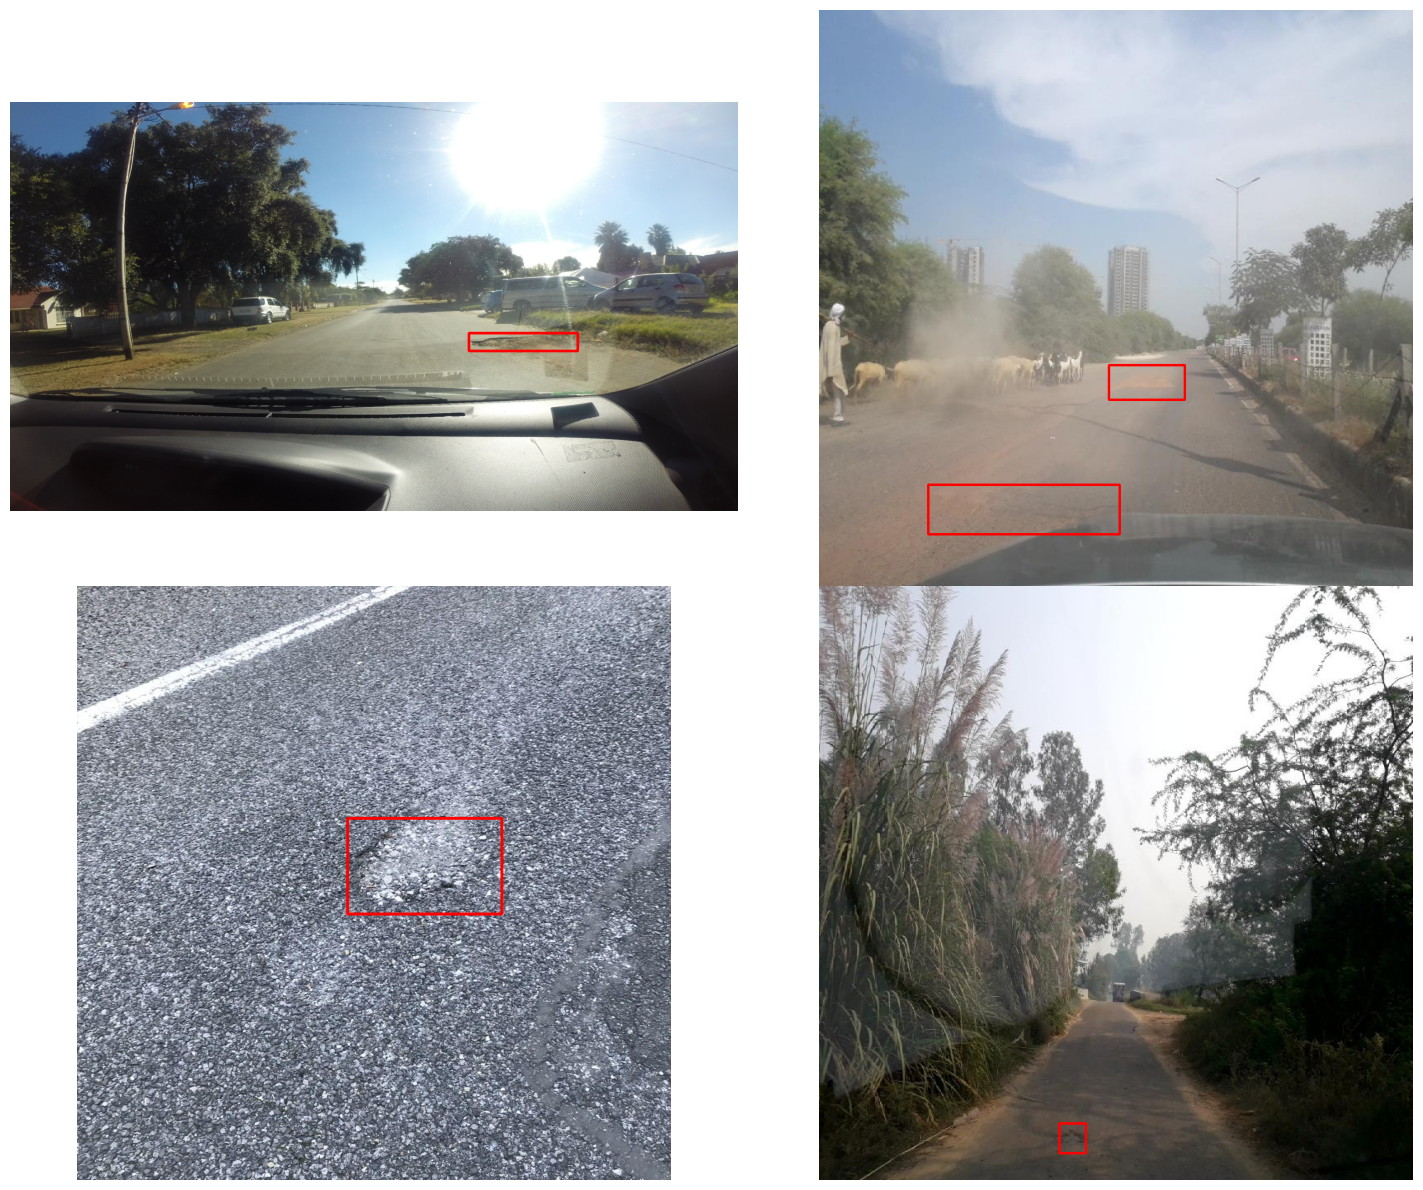

In [7]:
# Visualize a few training images.
plot(
    image_paths='pothole_dataset_v8/train/images/', 
    label_paths='pothole_dataset_v8/train/labels/',
    num_samples= 4,
)

## Dataset YAML File

In [9]:
%%writefile pothole_v8.yaml
path: 'pothole_dataset_v8/'
train: 'train/images'
val: 'valid/images'

# class names
names: 
  0: 'pothole'

Overwriting pothole_v8.yaml


## YOLOv8 Nano Training imgsz=640

In [9]:
# Sample training for 5 epoch.
EPOCHS = 100
!yolo task=detect mode=train model=yolov8n.pt imgsz=640 data=pothole_v8.yaml epochs={EPOCHS} batch=32 name=yolov8n_v8_50e

New https://pypi.org/project/ultralytics/8.2.32 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.31 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5905MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=pothole_v8.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v8_50e3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=

## Evaluation on Validation Images

In [14]:
!yolo task=detect mode=val model=runs/detect/yolov8n_v8_50e3/weights/best.pt name=yolov8n_eval data=pothole_v8.yaml

Ultralytics YOLOv8.2.31 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5905MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /home/jaykumaran/Blogs/Poth-hole-Detection/datasets/pothole_datase
val: WARNING ⚠️ /home/jaykumaran/Blogs/Poth-hole-Detection/datasets/pothole_dataset_v8/valid/images/G0011603.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /home/jaykumaran/Blogs/Poth-hole-Detection/datasets/pothole_dataset_v8/valid/images/G0011614.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /home/jaykumaran/Blogs/Poth-hole-Detection/datasets/pothole_dataset_v8/valid/images/G0011616.jpg: 2 duplicate labels removed
val: WARNING ⚠️ /home/jaykumaran/Blogs/Poth-hole-Detection/datasets/pothole_dataset_v8/valid/images/G0011661.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /home/jaykumaran/Blogs/Poth-hole-Detection/datasets/pothole_dataset_v8/valid/images/G0011662.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /home/j

## Inference on Validation Images

In [7]:
!yolo task=detect \
mode=predict \
model= datasets/runs/detect/yolov8n_v8_50_9602/weights/best.pt \
source= datasets/pothole_dataset_v8/valid/images\
imgsz= 960 \
name= video_infer_960_val \
hide_labels=True

WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.399999999999999' in the future. Please use 'show_labels' instead.
Ultralytics YOLOv8.2.35 🚀 Python-3.10.0 torch-2.3.1+cu121 CPU (13th Gen Intel Core(TM) i5-13420H)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

image 1/271 /home/jaykumaran/Blogs/Poth-hole-Detection/datasets/pothole_dataset_v8/valid/images/G0011195.jpg: 544x960 (no detections), 149.6ms
image 2/271 /home/jaykumaran/Blogs/Poth-hole-Detection/datasets/pothole_dataset_v8/valid/images/G0011196.jpg: 544x960 1 pothole, 141.1ms
image 3/271 /home/jaykumaran/Blogs/Poth-hole-Detection/datasets/pothole_dataset_v8/valid/images/G0011242.jpg: 544x960 2 potholes, 137.7ms
image 4/271 /home/jaykumaran/Blogs/Poth-hole-Detection/datasets/pothole_dataset_v8/valid/images/G0011243.jpg: 544x960 3 potholes, 140.7ms
image 5/271 /home/jaykumaran/Blogs/Poth-hole-Detection/datasets/pothole_dataset_v8/valid/images/G0011244.jpg: 544x960 1 pot

## Visualize Validation Results

In [18]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

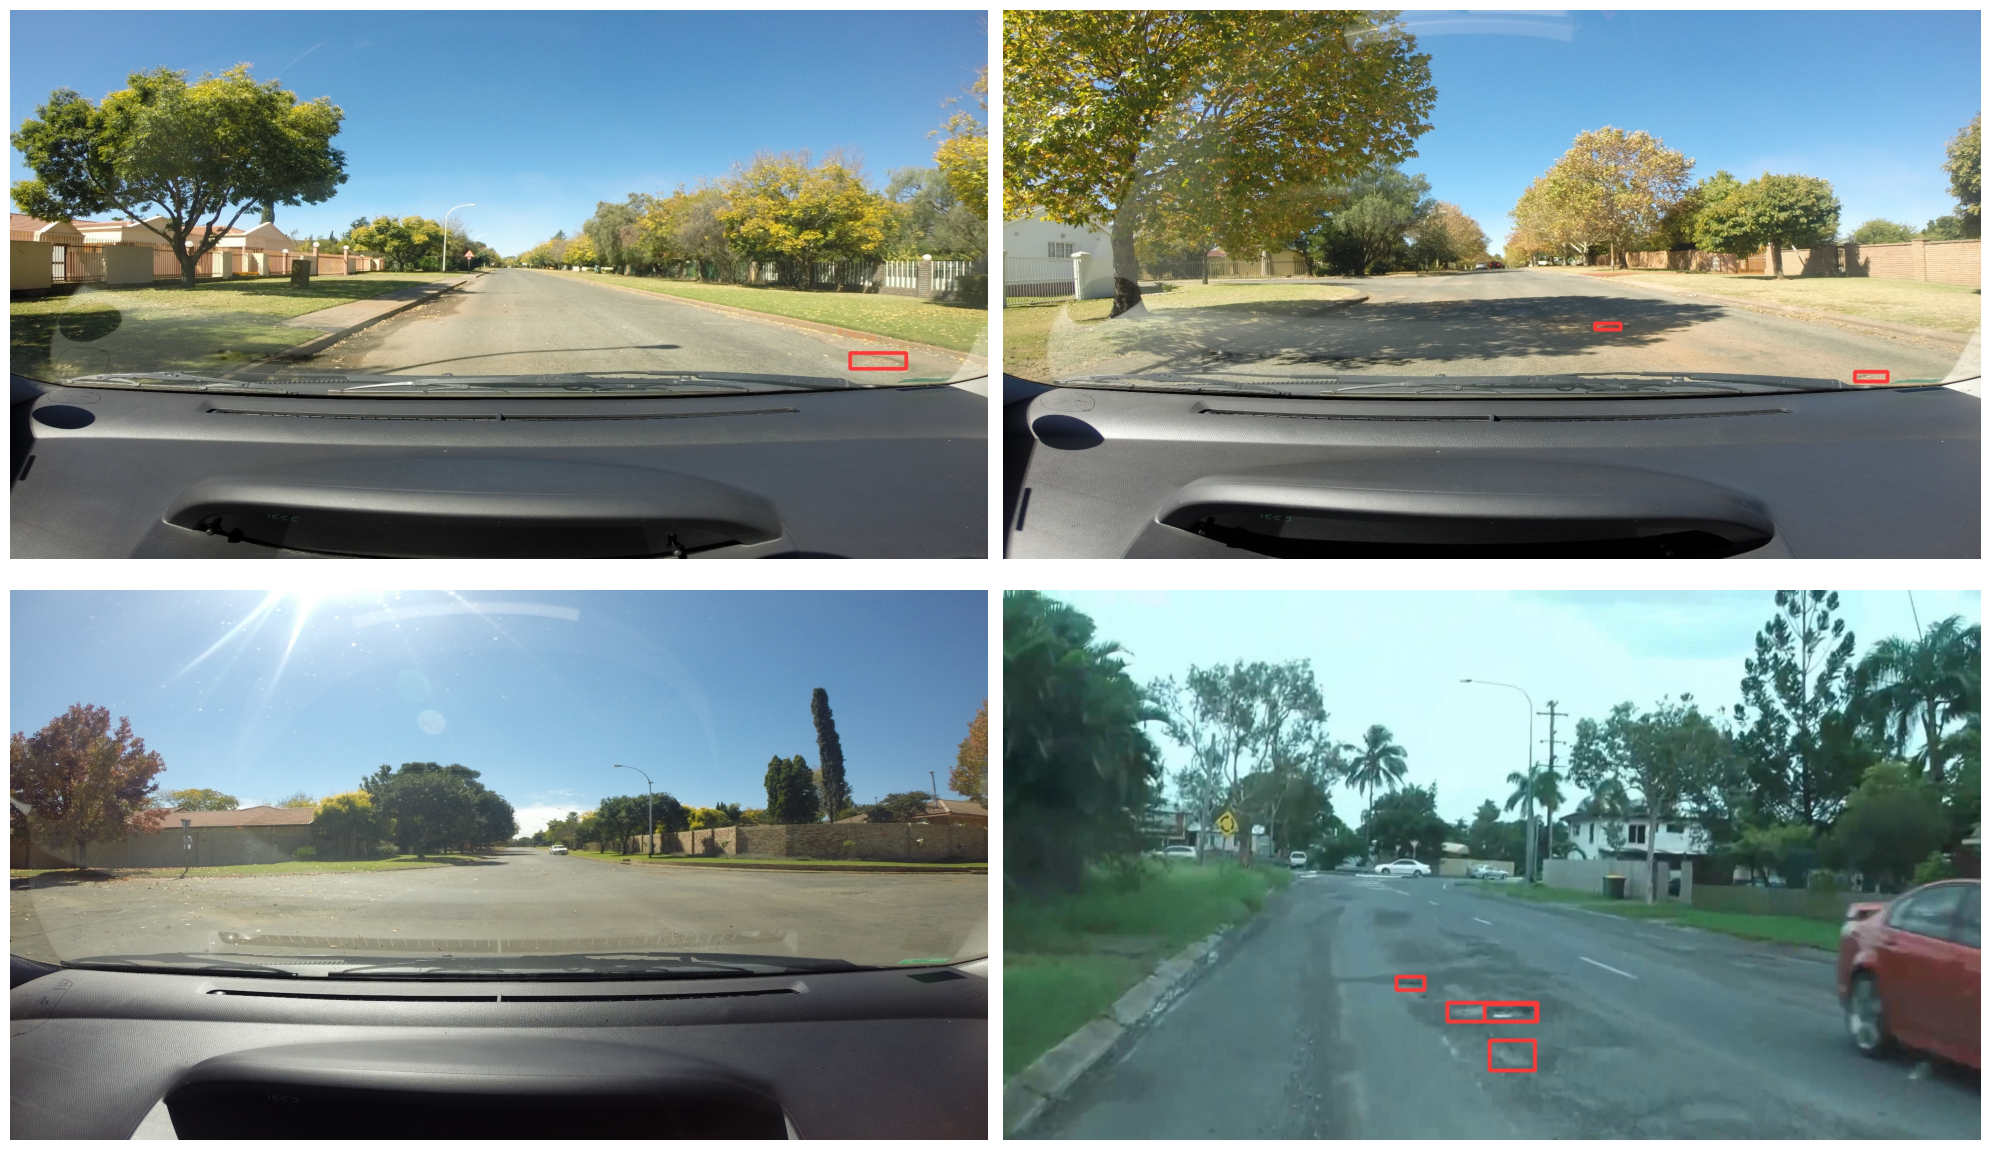

In [24]:
visualize('runs/detect/yolov8n_v8_50e_infer640/')

# Training YOLOv8n - 960 img sz

In [12]:
# Sample training for 5 epoch.
EPOCHS = 50
!yolo task=detect mode=train model=yolov8n.pt imgsz=960 data=pothole_v8.yaml epochs={EPOCHS} batch=16 name=yolov8n_v8_50_960

New https://pypi.org/project/ultralytics/8.2.34 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.31 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5905MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=pothole_v8.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=960, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v8_50_9602, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embe

<img src="https://learnopencv.com/wp-content/uploads/2024/06/results.png" width = 800 height = 400>

| MODEL   | TRAIN IMAGE SIZE | mAP@0.5 |
|---------|------------------|---------|
| YOLOv8n | (640, 640)       | 0.332   |
| YOLOv8n | (960, 960)       | **0.44** |
| YOLOv8n | (1280, 1280)     | 0.40    |
|YOLOV10n | (960, 960)       | 0.404   |


## Inference on Video

In [6]:
!yolo task=detect \
mode=predict \
model= datasets/runs/detect/yolov8n_v8_50_9602/weights/best.pt \
source= pothole_dataset_v8/valid/val_video.mp4\
imgsz= 960 \
name= video_infer_960_val \
hide_labels=True

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.399999999999999' in the future. Please use 'show_labels' instead.
Ultralytics YOLOv8.2.35 🚀 Python-3.10.0 torch-2.3.1+cu121 CPU (13th Gen Intel Core(TM) i5-13420H)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

video 1/1 (frame 1/271) /home/jaykumaran/Blogs/Poth-hole-Detection/pothole_dataset_v8/valid/val_video.mp4: 544x960 (no detections), 146.1ms
video 1/1 (frame 2/271) /home/jaykumaran/Blogs/Poth-hole-Detection/pothole_dataset_v8/valid/val_video.mp4: 544x960 1 pothole, 144.7ms
video 1/1 (frame 3/271) /home/jaykumaran/Blogs/Poth-hole-Detection/pothole_dataset_v8/valid/val_video.mp4: 544x960 2 potholes, 143.3ms
video 1/1 (frame 4/271) /home/jaykumaran/Blogs/Poth-hole-Detection/pothole_dataset_v8/valid/val_video.mp4: 544x960 3

<img src="https://learnopencv.com/wp-content/uploads/2024/06/direct-pred-val_video-e.gif">

****************************************************************************************************************************************************************************************************************

# Luxonis YOLO to Blob Direct Conversion Toolkit

Tooklit: https://tools.luxonis.com/

<img src="https://learnopencv.com/wp-content/uploads/2024/06/Yolo-conversion.png" width=500 height=400>

****************************************************************************************************************************************************************************************************************

## Convert YOLOv8n to OpenVINO IR FORMAT

<img src="https://docs.openvino.ai/archive/2023.2/_images/ov_homepage_diagram.png" width=500 height=400>

In [3]:
model = YOLO('/home/jaykumaran/Blogs/Poth-hole-Detection/datasets/runs/detect/yolov8n_v8_50_9602/weights/best.pt')

In [4]:
model.export(format='openvino', imgsz = (960,960))

Ultralytics YOLOv8.2.35 🚀 Python-3.10.0 torch-2.3.1+cu121 CPU (13th Gen Intel Core(TM) i5-13420H)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/home/jaykumaran/Blogs/Poth-hole-Detection/datasets/runs/detect/yolov8n_v8_50_9602/weights/best.pt' with input shape (1, 3, 960, 960) BCHW and output shape(s) (1, 5, 18900) (6.0 MB)

OpenVINO: starting export with openvino 2024.2.0-15519-5c0f38f83f6-releases/2024/2...
OpenVINO: export success ✅ 3.1s, saved as '/home/jaykumaran/Blogs/Poth-hole-Detection/datasets/runs/detect/yolov8n_v8_50_9602/weights/best_openvino_model/' (11.9 MB)

Export complete (5.0s)
Results saved to /home/jaykumaran/Blogs/Poth-hole-Detection/datasets/runs/detect/yolov8n_v8_50_9602/weights
Predict:         yolo predict task=detect model=/home/jaykumaran/Blogs/Poth-hole-Detection/datasets/runs/detect/yolov8n_v8_50_9602/weights/best_openvino_model imgsz=960  
Validate:        yolo val task=detect model=/home/jaykumaran

'/home/jaykumaran/Blogs/Poth-hole-Detection/datasets/runs/detect/yolov8n_v8_50_9602/weights/best_openvino_model'

****************************************************************************************************************************************************************************************************************

# Blob Conversion From OpenVINO IR or ONNX

Toolkit: https://blobconverter.luxonis.com/

<img src ="https://learnopencv.com/wp-content/uploads/2024/06/BlobConverter-Interface.png">

<img src="https://learnopencv.com/wp-content/uploads/2024/06/BlobConverter-actual.png" width=800 height=500>

****************************************************************************************************************************************************************************************************************

<img src="https://learnopencv.com/wp-content/uploads/2024/06/Oak-devices-edited-scaled.jpg" width=400 height = 300>

****************************************************************************************************************************************************************************************************************

# YOLOv10 imgsz=960

Clone yolov10 repo and install dependencies incase of `dill` error

https://github.com/ultralytics/ultralytics/issues/13295

In [11]:
!git clone https://github.com/THU-MIG/yolov10.git

Cloning into 'yolov10'...
remote: Enumerating objects: 20299, done.
remote: Counting objects: 100% (1342/1342), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 20299 (delta 1299), reused 1220 (delta 1220), pack-reused 18957
Receiving objects: 100% (20299/20299), 11.18 MiB | 856.00 KiB/s, done.
Resolving deltas: 100% (14302/14302), done.


In [12]:
cd yolov10

/home/jaykumaran/Blogs/Poth-hole-Detection/yolov10


/home/jaykumaran/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [14]:
!pip install -q .

In [18]:
!pip install -q huggingface_hub

In [16]:
cd ..

/home/jaykumaran/Blogs/Poth-hole-Detection


In [20]:
# Sample training for 5 epoch.
EPOCHS = 50
!yolo task=detect mode=train model=yolov10n.pt imgsz=960 data=pothole_v8.yaml epochs={EPOCHS} batch=8 name=yolov10n_v10_50_960

New https://pypi.org/project/ultralytics/8.2.34 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5905MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=pothole_v8.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=960, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=yolov10n_v10_50_9602, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_m

****************************************************************************************************************************************************************************************************************